In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import logit, expit
from scipy.stats import uniform, norm, bernoulli
from statsmodels.stats.proportion import proportions_ztest
from matplotlib import pyplot as plt
import pymc as pm
import arviz as az
import jax
from pymc.sampling_jax import sample_numpyro_nuts
from time import time
import pickle

from modeltools import mcmc_diagnostics, create_summary_stat
from downcast import downcast_df
from simulatescores import simulate_scores

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/roger/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/roger/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
2022-10-24 14:34:52.190676: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-24 14:34:52.216635: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared 

In [2]:
#  Setting up seeds
seed = 42

# Setting numpy seed
np.random.seed(seed)

# GPU setting
SAMPLE_JAX = True

In [3]:
import sys
import importlib
importlib.reload(sys.modules['simulatescores'])
from simulatescores import simulate_scores

In [4]:
raw_data = pd.read_csv("data/unit_level_ratings.csv",index_col = 0)
raw_data = raw_data.sort_values(by=["corpus", "model", "topic"])

In [5]:
# Creating identifier for each corpus, model, and topic
# Identifier is unique for topic 
corpus_ids = (raw_data.groupby(["corpus"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
corpus_ids["corpus_id"] = corpus_ids.index

model_ids = (raw_data.groupby(["model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
model_ids["model_id"] = model_ids.index

cordel_ids = (raw_data.groupby(["corpus", "model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
cordel_ids["cordel_id"] = cordel_ids.index 

topic_ids = (raw_data.groupby(["corpus", "model", "topic"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
topic_ids["topic_id"] = topic_ids["topic"].astype(np.int16)

rater_ids = (raw_data.groupby(["corpus", "rater"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
rater_ids["rater_id"] = rater_ids.index 


d1 = pd.merge(raw_data, corpus_ids, on=["corpus"], how="left")
d2 = pd.merge(d1, model_ids, on=["model"], how="left")
d3 = pd.merge(d2, cordel_ids, on=["corpus","model"], how="left")
d4 = pd.merge(d3, rater_ids, on=["corpus", "rater"], how="left")
data = pd.merge(d4, topic_ids, on=["corpus", "model", "topic"], how="left")
data = data[["corpus_id", "model_id", "cordel_id", "topic_id", "rater_id", "intrusion", "confidence"]]
data, na_s = downcast_df(data)

In [6]:
# Setting up numpy arrays for pymc
corpus_array = np.array(data["corpus_id"])
n_corpora = data["corpus_id"].nunique()

model_array = np.array(data["model_id"])
n_models = data["model_id"].nunique()

cordel_array = np.array(data["cordel_id"])
n_cordels = data["cordel_id"].nunique()

topic_array = np.array([data["cordel_id"], data["topic_id"]])
n_topics = data["topic_id"].nunique()

rater_array = np.array(data["rater_id"])
obs_n_raters = data["rater_id"].nunique()

score_array = np.array(data["intrusion"])



In [7]:
# Adding cordel id to topic_ids dataframe
topic_cordel_ids = pd.merge(topic_ids, cordel_ids, on=["corpus", "model"], how="left")

## Bayesian Model

In [8]:
# Model and MCMC specifications

n_chains = 6
empirical_mean = logit(0.75)
r_lambda = 2
t_lambda = 1
t_sigma = 1
# cm_lambda = 2
# cm_sigma = 1
mu_sigma = 1

glm_rater_topic_cordel = {"model":pm.Model()}

In [9]:
# Rater, Topic, Cordel model

glm_rater_topic_cordel["model"] = pm.Model()
with glm_rater_topic_cordel["model"]:
    # Hyperparameter priors
    raters = pm.Data("raters", rater_array, mutable=True, dims="obs_id")
    topics = pm.Data("topics", topic_array, mutable=True, dims=["cordel", "topic"])
    cordels = pm.Data("cordels", cordel_array, mutable=True, dims="obs_id")
    
    sigma_r = pm.Exponential("sigma_r", lam=r_lambda)
    zr = pm.Normal("zr",mu=0, sigma=1, shape=obs_n_raters)
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
    za = pm.Normal("za",mu=0, sigma=t_sigma, shape=(n_cordels, n_topics)) 
    mu = pm.Normal("mu",mu=empirical_mean, sigma=mu_sigma, shape=n_cordels)
    
    s = pm.Bernoulli(
            "s", 
            p=pm.math.invlogit(
                mu[cordels]+
                za[topics[0],topics[1]]*sigma_a+
                zr[raters]*sigma_r),
            observed=score_array, 
            dims="obs_id")

    c_mean = pm.Deterministic("c_mean", 
                              pm.math.invlogit(mu + (za.T*sigma_a)).mean(axis=0), 
                              dims="obs_id")
    
    if SAMPLE_JAX:
        glm_rater_topic_cordel["trace"]=sample_numpyro_nuts(chains=n_chains, random_seed=seed)#, chain_method="vectorized")
    else:
        glm_rater_topic_cordel["trace"]=pm.sample(chains=n_chains, random_seed=seed)

Compiling...


2022-10-24 14:34:55.055400: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-24 14:34:55.055422: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


Compilation time =  0:00:02.088853
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:01:06.957784
Transforming variables...
Transformation time =  0:00:00.580019
Computing Log Likelihood...
Log Likelihood time =  0:00:06.463737


In [10]:
glm_rater_topic_cordel["summary_stat"] = create_summary_stat(glm_rater_topic_cordel["trace"])

## Functions

In [11]:
def calculate_raters(n_raters=None, scores_per_r=None, total_scores=None):
#     Calculate if missing one and only one argument
    count_none = sum([n_raters ==None, scores_per_r ==None, total_scores ==None])
    assert(count_none == 1)
    
    if n_raters == None:
        n_raters = total_scores//scores_per_r + 1
    
    if scores_per_r == None:
        scores_per_r = total_scores//n_raters + 1
    
    if total_scores == None:
        total_scores = n_raters*scores_per_r
    
    return n_raters, scores_per_r, total_scores
         

In [12]:
def simulate_scores(model, p_diff=0.08, n_raters=40, scores_per_r=40, n_trials=1_000):
    
    def resample(all_ids, param, size, bound=0.1):
        # resampling raters and topics such that effects sum to 0.

        s = model["summary_stat"][model["summary_stat"]["param"]==param].copy(deep=True)

        if param == "za":
            s[["a", "b"]] = s["param_num"].str.split(", ", expand=True)
            s["param_num"] = (s["a"].astype(int)*50 + s["b"].astype(int)).astype(str)

        mean_sum = 9999
        while mean_sum < -bound or mean_sum > bound:
            ids = np.random.choice(all_ids, size=size, replace=True)
            mean_sum = sum([s[(s["param_num"]==str(i))]["mean"].item() for i in ids])
    
        return ids

    start_time = time()
  
    ps_data = pd.DataFrame(columns=["trial_id", "sim_cordel_id", "sim_topic_id", "sim_rater_id", 
                                    "cordel_id", "topic_id", "rater_id"], dtype=np.int16)

    for trial_id in range(n_trials):

        # data template
        sim_data = pd.DataFrame(columns=["trial_id", "cordel_id", "topic_id", "rater_id"])  

        # Raters in this simulation
        raters = resample(data["rater_id"].unique(), param="zr", size=n_raters, bound=1)


        # Topics in this simulation (topic_cordel_ids index values)
        sim_topics_0 = resample(range(len(topic_cordel_ids)), param="za", size=50, bound=1)
        sim_topics_1 = resample(range(len(topic_cordel_ids)), param="za", size=50, bound=1)
        sim_topics = np.concatenate((sim_topics_0, sim_topics_1))

        # Count of scores for each topic
        counts = np.zeros(100)

        for sim_rater_id, rater in enumerate(raters):
        #     Set the probability. Topics with fewer samples have higher probability
            counts = counts-counts.min()+1
            p = 1/counts**20
            p = p/p.sum()

        #     Sample according to probability
            rated_topics = np.random.choice(range(100), size=scores_per_r, replace=False, p=p)
            rated_topics_idx = sim_topics[rated_topics]
            counts[rated_topics] += 1

        #     Append topics to simulation
            d=topic_cordel_ids.loc[rated_topics_idx, ["topic_id", "cordel_id"]]
            d["sim_rater_id"]=sim_rater_id
            d["sim_topic_id"]=rated_topics
            d["rater_id"]=rater

            sim_data = pd.concat([sim_data, d], axis="rows", ignore_index=True)

    #     Adding one topic/rater interaction into df
        sim_data["trial_id"] = trial_id
        sim_data.loc[sim_data["sim_topic_id"].isin(range(0,50)),["sim_cordel_id"]] = 0
        sim_data.loc[sim_data["sim_topic_id"].isin(range(50,100)),["sim_cordel_id"]] = 1
    #     sim_data = pd.merge(sim_data, topic_counts[["cordel_id", "topic_id", "sim_cordel_id"]]
    #                         ,on=["cordel_id", "topic_id"], how="left")
        sim_data=sim_data.astype(np.int16)

    #     Appending interaction to ds.
        ps_data = pd.concat([ps_data, sim_data], ignore_index=True)
    
    print(f"Completed simulating topic/rater interactions in {time() - start_time:.2f}s")
    
#     Simulating Scores
    pymc_model = model["model"]
    trace = model["trace"].copy()

    # Calculating proposed logodds means
    # model1 = model0 + p
    # https://www.wolframalpha.com/input?i=solve+for+x+and+y%2C+x%2By%3Dc%2C+1%2F%281%2Be%5E-x%29-1%2F%281%2Be%5E-y%29%3Dp
    mean_model_logodds = model["summary_stat"][model["summary_stat"]["param"]=="mu"]["mean"].mean()
    c = 2*mean_model_logodds
    C = np.exp(-c)
    det = p_diff**2-2*C*(p_diff**2-2)+(C**2)*(p_diff**2)
    quad = (-p_diff*(C+1)+det**0.5)/(2*(p_diff+1))
    proposed_model1_mean = -np.log(quad)
    proposed_model0_mean = c-proposed_model1_mean
    
    # Setting trace of cordel 0 and cordel 1 to proposed values
    trace.posterior["mu"].loc[dict(mu_dim_0=0)] = proposed_model0_mean
    trace.posterior["mu"].loc[dict(mu_dim_0=1)] = proposed_model1_mean
    
    sim_scores = pd.DataFrame(columns=["trial_id", "sim_cordel_id", "sim_topic_id", "sim_rater_id", "cordel_id", "topic_id", "rater_id", "intrusion", ]
                       ,dtype=np.int16)
    
# TODO: add chain options
    for trial_id in range(n_trials):
        # Setting data containing rater/topic interaction
        sim_data = ps_data[ps_data["trial_id"]==trial_id]
        sim_rater_array = np.array(sim_data["rater_id"], dtype=int)
        topic_array = np.array([sim_data["cordel_id"], sim_data["topic_id"]], dtype=int)
        cordel_array = np.array(sim_data["sim_cordel_id"], dtype=int)

        # Running simulation
        with pymc_model:
            pm.set_data({
                "raters":sim_rater_array, 
                "topics":topic_array, 
                "cordels":cordel_array})
            postrr_sim=pm.sample_posterior_predictive(trace.posterior.sel(
                {"chain":[0], "draw":[np.random.randint(n_trials) if n_trials==1 else trial_id]})
                ,predictions=True, progressbar=False, random_seed=np.random.randint(2**20))

        # Adding results to sim_scores
        s = (postrr_sim.predictions.to_dataframe().reset_index()
              .rename(columns={"s":"intrusion"}))
        this_sim_scores = pd.concat([sim_data.reset_index(drop=True)
                                     ,s["intrusion"]], axis="columns").astype(np.int16)
        sim_scores = pd.concat([sim_scores, this_sim_scores], axis="index", ignore_index=True)
    
    print(f"Completed simulating scores in {time() - start_time:.2f}s")
    return sim_scores

In [13]:
def generate_sim_settings(n_sims, p_diff, n_raters=None, scores_per_r=None, total_scores=None):
#     n_sims = 10
#     p_diff = (0.02, 0.2)
#     n_raters = (20, 100)
#     scores_per_r = 40
#     total_scores = 1300
    # Checking only 2 of 3 score and rater variables is declared
    count_none = sum([n_raters == None, scores_per_r == None, total_scores == None])
    assert count_none == 1, "There should be 2 score/rater variables declared"

    # Sampling uniform random variables
    if type(p_diff) == tuple:
        col_p_diff = uniform.rvs(loc = p_diff[0], scale=p_diff[1]-p_diff[0], size=n_sims)
    else:
        col_p_diff = np.array([p_diff]*n_sims)

    if type(n_raters) == tuple:
        col_n_raters = np.random.randint(n_raters[0], high=n_raters[1], size=n_sims)
    else:
        col_n_raters = np.array([n_raters]*n_sims)

    if type(scores_per_r) == tuple:
        col_scores_per_r = np.random.randint(scores_per_r[0], high=scores_per_r[1], size=n_sims)
    else:
        col_scores_per_r = np.array([scores_per_r]*n_sims)
    
    if type(total_scores) == tuple:
        col_total_scores = np.random.randint(total_scores[0], high=total_scores[1], size=n_sims)
    else:
        col_total_scores = np.array([total_scores]*n_sims)

    # Calculating remaining column
    if n_raters == None:
        col_n_raters = (col_total_scores-1)//col_scores_per_r + 1
    elif scores_per_r == None:
        col_scores_per_r = (col_total_scores-1)//col_n_raters + 1
    elif total_scores == None:
        col_total_scores = col_scores_per_r * col_n_raters
    else:
        raise Exception("How did you even get this exception? Should've been impossible, but congratulations")
        
    df = pd.DataFrame(
        np.array([col_p_diff, col_n_raters, col_scores_per_r, col_total_scores]).T,
        columns=["p_diff", "n_raters", "scores_per_r", "total_scores"])
    
    df = df.astype({
        "p_diff":float,
        "n_raters":np.uint16,
        "scores_per_r":np.uint16,
        "total_scores":np.uint16
    })

      
    return df

In [14]:
def propz_pval(scores):
    # Utests whether the two distributions in the scores are statisticaly significant
    # returns 1 if cordel 1 intrusion scores is statistically higher
    # returns 0 if no statistical difference
    # returns -1 if cordel 2 intrusion scores are statistically higher 

    
    sum_df = scores.groupby(["sim_cordel_id"]).agg({"intrusion":"sum"}).reset_index()
    cordel0_sums = sum_df[sum_df["sim_cordel_id"]==0]["intrusion"]
    cordel1_sums = sum_df[sum_df["sim_cordel_id"]==1]["intrusion"]
    
    count_df = scores.groupby(["sim_cordel_id"]).agg({"intrusion":"count"}).reset_index()
    cordel0_counts = count_df[count_df["sim_cordel_id"]==0]["intrusion"]
    cordel1_counts = count_df[count_df["sim_cordel_id"]==1]["intrusion"]
    
    _, p_val = proportions_ztest([cordel0_sums, cordel1_sums],
                                 [cordel0_counts, cordel1_counts],
                                 alternative="smaller")
    
    return p_val


In [15]:
def bht_pval(sample, n_chains):
# sample = scores[scores["trial_id"]==0]

# Bayesian hypothesis tests whether the two distributions in the sample are statisticaly significant
# Setting up numpy arrays for pymc
# Only 2 models and 1 corpus in simulation
    corpus_array = np.array([0]*len(sample))
    n_corpora = 1

    model_array = np.array(sample["sim_cordel_id"])
    n_models = sample["sim_cordel_id"].nunique()

    cordel_array = np.array(sample["sim_cordel_id"])
    n_cordels = sample["sim_cordel_id"].nunique()

    topic_array = np.array([sample["sim_cordel_id"], sample["sim_topic_id"]])
    n_topics = sample["sim_topic_id"].nunique()

    rater_array = np.array(sample["sim_rater_id"])
    n_raters = sample["sim_rater_id"].nunique()

    score_array = np.array(sample["intrusion"])


    # Model and MCMC specifications
    empirical_mean = logit(0.75)
    r_lambda = 2
    t_lambda = 1
    t_sigma = 1
    # cm_lambda = 2
    # cm_sigma = 1
    mu_sigma = 1

    glm = {"model":pm.Model()}

    # Rater, Topic, Cordel model

    glm["model"] = pm.Model()
    with glm["model"]:
        # Hyperparameter priors
        raters = pm.Data("raters", rater_array, mutable=True, dims="obs_id")
        topics = pm.Data("topics", topic_array, mutable=True, dims=["cordel", "topic"])
        cordels = pm.Data("cordels", cordel_array, mutable=True, dims="obs_id")

        sigma_r = pm.Exponential("sigma_r", lam=r_lambda)
        zr = pm.Normal("zr",mu=0, sigma=1, shape=n_raters)
        sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
        za = pm.Normal("za",mu=0, sigma=t_sigma, shape=(n_cordels, n_topics)) 
        mu = pm.Normal("mu",mu=empirical_mean, sigma=mu_sigma, shape=n_cordels)

        s = pm.Bernoulli(
                "s", 
                p=pm.math.invlogit(
                    mu[cordels]+
                    za[topics[0],topics[1]]*sigma_a+
                    zr[raters]*sigma_r),
                observed=score_array, 
                dims="obs_id")

        c_mean = pm.Deterministic("c_mean", 
                                  pm.math.invlogit(mu + (za.T*sigma_a)).mean(axis=0), 
                                  dims="obs_id")
        c_diff = pm.Deterministic("c_diff", c_mean.reshape([n_cordels,1]) - c_mean.reshape([1,n_cordels]), dims="obs_id")

        if SAMPLE_JAX:
            glm["trace"]=sample_numpyro_nuts(chains=n_chains, random_seed=np.random.randint(2**20))#, chain_method="vectorized")
        else:
            glm["trace"]=pm.sample(chains=n_chains, random_seed=np.random.randint(2**20))

    n_negatives = (glm["trace"].posterior["c_diff"].sel({"obs_id":1, "c_diff_dim_1":0}) < 0).sum().item()
    
    return  n_negatives/len(sample)

In [16]:
def simulate_sig_tests(n_sims, p_diff, n_raters=None, scores_per_r=None, 
                       total_scores=None, trials_per_sim=1, np_random_state=None, n_chains=1):
# Bug: Random_state only reproduces scores. Does not reproduce bayesian inference.
# Reproduce usage: set np_random_state to index of simulation/trial (sim_id*trials_per_sim + trial_id)

    if np_random_state!=None:
        n_sims=1
        trials_per_sim=1

    # Checking only 2 of 3 score and rater variables is declared
    count_none = sum([n_raters == None, scores_per_r == None, total_scores == None])
    assert(count_none == 1)

    # Generate settings for each simulation
    settings_df = generate_sim_settings(n_sims=n_sims, p_diff=p_diff, n_raters=n_raters, 
                                        scores_per_r=scores_per_r, total_scores=total_scores)
    
    for sim_id in range(n_sims):
        # Reading settings
        p_diff = settings_df.loc[sim_id, "p_diff"].item()
        n_raters = settings_df.loc[sim_id, "n_raters"].item()
        scores_per_r = settings_df.loc[sim_id, "scores_per_r"].item()
        total_scores = settings_df.loc[sim_id, "total_scores"].item()
        
        # Reading or dumping np.random.RandomState
        if np_random_state==None:
            with open(f"data/{out}/{sim_id*trials_per_sim}.pickle", "wb") as f:
                pickle.dump(np.random.get_state(), f)
        else:
            with open(f"data/{out}/{np_random_state}.pickle", "rb") as f:
                np.random.set_state(pickle.load(f))
        
        scores = simulate_scores(
            glm_rater_topic_cordel,
            p_diff=p_diff,
            n_raters=n_raters,
            scores_per_r=scores_per_r,
            n_trials=trials_per_sim)

        for trial_id in range(trials_per_sim):
            if trial_id != 0:
                with open(f"data/{out}/{sim_id*trials_per_sim+trial_id}.pickle", "wb") as f:
                        pickle.dump(np.random.get_state(), f)
            
            sim_results = pd.DataFrame(
                [[sim_id, p_diff, n_raters, scores_per_r, total_scores, trial_id, 
                 propz_pval(scores[scores["trial_id"]==trial_id]),
                 bht_pval(scores[scores["trial_id"]==trial_id], n_chains=n_chains)]],
                columns=["sim_id", "p_diff", "n_raters",  "scores_per_r", "total_scores", "trial_id", 
                         "propz_pval", "bht_pval"])

            sim_results = sim_results.astype({
                "sim_id":int,
                "trial_id":int,
                "p_diff":float,
                "n_raters":np.uint16,
                "scores_per_r":np.uint16, 
                "total_scores":np.uint16,
                "propz_pval":float, 
                "bht_pval":float,
            })
            

            if np_random_state==None:
                with open(f"data/{out}/{out}.csv", mode="a") as f:
                    f.write(sim_results.to_csv(None, index=False, header=False))
                print(f"Simulation:{sim_id}, Trial:{trial_id}")
            else:
                return scores, sim_results
    
    return

## Simulation

In [17]:
# Settings for hoyle's significance testing
hoyle_total_scores = 50*26
hoyle_p_diff = 0.055
hoyle_n_raters = 38
hoyle_scores_per_r = hoyle_total_scores//hoyle_n_raters + 1

In [18]:
# total ratings between 400 and 2400
# Hoyle used 1300 total ratings
out = "test"
try:
    with open(f"data/simulations/{out}.csv", mode="w") as f:
        f.write('sim_id,p_diff,n_raters, scores_per_r,total_scores,trial_id,propz_pval,bht_pval\n')
except FileExistsError:
    pass

sim_n_raters = simulate_sig_tests(
    p_diff = hoyle_p_diff,
    n_raters = (10, 60),
    scores_per_r = hoyle_scores_per_r,
    n_sims = 2,
    trials_per_sim = 1
)

Sampling: [s]
INFO:pymc:Sampling: [s]


Completed simulating topic/rater interactions in 0.83s
Completed simulating scores in 1.02s
Compiling...
Compilation time =  0:00:00.622816
Sampling...


sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 223.56it/s, 15 steps of size 3.15e-01. acc. prob=0.84]


Sampling time =  0:00:11.524169
Transforming variables...
Transformation time =  0:00:00.474518
Computing Log Likelihood...
Log Likelihood time =  0:00:00.844997
Simulation:0, Trial:0


Sampling: [s]
INFO:pymc:Sampling: [s]


Completed simulating topic/rater interactions in 0.63s
Completed simulating scores in 0.79s
Compiling...
Compilation time =  0:00:00.614142
Sampling...


sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.90it/s, 15 steps of size 3.23e-01. acc. prob=0.84]


Sampling time =  0:00:10.057235
Transforming variables...
Transformation time =  0:00:00.074357
Computing Log Likelihood...
Log Likelihood time =  0:00:00.759085
Simulation:1, Trial:0


In [ ]:
sim_scores_per_r = simulate_sig_tests(
    p_diff = hoyle_p_diff,
    scores_per_r = (10, 100),
    total_scores = hoyle_total_scores,
    trials_per_sim = 1,
    n_sims = 10
)

In [ ]:
# total ratings between 400 and 2400
# Hoyle used 1300 total ratings
sim_p_n_raters = simulate_sig_tests(
    p_diff = (0.02, 0.2),
    n_raters = (10, 60),
    scores_per_r = hoyle_scores_per_r,
    trials_per_sim = 1,
    n_sims = 10
)

In [ ]:
sim_p_scores_per_r = simulate_sig_tests(
    p_diff = (0.02, 0.2),
    scores_per_r = (10, 100),
    total_scores = hoyle_total_scores,
    trials_per_sim = 1,
    n_sims = 10
)

## Plots

In [152]:
alpha = 0.05
sim_results["utest"] = sim_results["utest_pval"] < alpha
sim_results["bht"] = sim_results["bht_pval"] < alpha

# (utest, bht)
# Neither significant: orange
# bht significant: yellow
# utest significant: blue
# both significant: green

sim_results["c"] = np.select(
    condlist=[
        ~sim_results["utest"] & ~sim_results["bht"],
        ~sim_results["utest"] & sim_results["bht"],
        sim_results["utest"] & ~sim_results["bht"],
        sim_results["utest"] & sim_results["bht"]
    ],
    choicelist=["orangered", "yellow", "blue", "green"],
    default="black")

legend = {
    "orangered":"Neither significant",
    "yellow":"BHT significant",
    "blue": "utest significant",
    "green": "Both signficant"
}

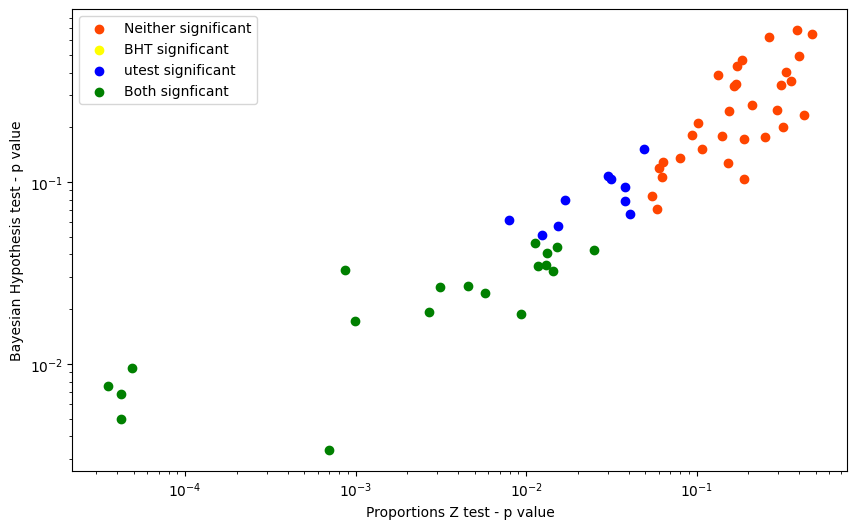

In [156]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
for colour in legend:
    df = sim_results[sim_results["c"]==colour]
    ax.scatter(df["utest_pval"], df["bht_pval"], c=colour, label=legend[colour])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Proportions Z test - p value")
ax.set_ylabel("Bayesian Hypothesis test - p value")
ax.legend()
plt.show()

. \
. \
. \
. \
. \
. \
. \
. 
## Checking score simulation script

In [ ]:
# Simulating scores
p_diff = 0.08
n_raters = 40
scores_per_r = 40
n_sims = 1_000
np.random.seed(seed)

In [ ]:
scores = simulate_scores(
    glm_rater_topic_cordel,
    p_diff=p_diff,
    n_raters=n_raters,
    scores_per_r=scores_per_r)

In [ ]:
sim_scores = scores.copy(deep=True)

In [ ]:
# Checking scores

_, ax = plt.subplots(2,1,figsize=(10,10))

n_ratings_per_cordel = n_raters*scores_per_r/2

sns.kdeplot(sim_scores[sim_scores["sim_cordel_id"]==0].groupby(["sim_id"]).agg({"intrusion":"sum"})["intrusion"]/n_ratings_per_cordel, ax=ax[0])
sns.kdeplot(sim_scores[sim_scores["sim_cordel_id"]==1].groupby(["sim_id"]).agg({"intrusion":"sum"})["intrusion"]/n_ratings_per_cordel, ax=ax[0])
ax[0].legend(ax[0].get_lines(), ["Cordel 0 means", "Cordel 1 means"])
ax[0].set_xlabel("Cordel means (probability)")
ax[0].set_title(f"Simulated means by cordel")

diff = sim_scores[sim_scores["sim_cordel_id"]==1].groupby(["sim_id"]).agg({"intrusion":"sum"}) \
        - sim_scores[sim_scores["sim_cordel_id"]==0].groupby(["sim_id"]).agg({"intrusion":"sum"})

sns.kdeplot(diff["intrusion"]/n_ratings_per_cordel, ax=ax[1])
ax[1].set_title(f"Difference in cordel means")
plt.plot()

print(f"Perc of simulations with mean1 < mean0 (n raters={n_raters}): {(diff['intrusion']<=0).sum()/1000:.1%}")

In [ ]:
size=100

_, ax = plt.subplots(1,1,figsize=(10,5))


# Selecting 100 random simulations
rand_ids = np.random.choice(range(1000), size=size, replace=False)

# Calculating topic proportions
samples = (sim_scores[sim_scores["sim_id"].isin(rand_ids)].groupby(["sim_id", "sim_topic_id"])
           .agg({"intrusion":["sum", "count"]}).reset_index())
samples["p"] = samples[("intrusion", "sum")]/samples[("intrusion", "count")]
# Plotting proportions
for sim_id in rand_ids:
    sns.kdeplot(samples[samples["sim_id"]==sim_id]["p"], ax=ax, color="navy", alpha=7/size**0.9)

# Repeat calculations and plots for actual data
actuals = (data.groupby(["cordel_id", "topic_id"])
           .agg({"intrusion":["sum", "count"]}).reset_index())
actuals["p"]=actuals[("intrusion", "sum")]/actuals[("intrusion", "count")]
for cordel_id in range(6):
    sns.kdeplot(actuals[actuals["cordel_id"]==cordel_id]["p"], ax=ax, color="orange", alpha=0.7)

ax.set_title("Simulated topic probabilities (blue) vs actual topic probabilities (orange)")
plt.show()

In [ ]:
size=100

_, ax = plt.subplots(1,1,figsize=(10,5))


# Selecting 100 random simulations
rand_ids = np.random.choice(range(1000), size=size, replace=False)

# Calculating rater proportions
samples = (sim_scores[sim_scores["sim_id"].isin(rand_ids)].groupby(["sim_id", "sim_rater_id"])
           .agg({"intrusion":["sum", "count"]}).reset_index())
samples["p"] = samples[("intrusion", "sum")]/samples[("intrusion", "count")]
# Plotting proportions
for sim_id in rand_ids:
    sns.kdeplot(samples[samples["sim_id"]==sim_id]["p"], ax=ax, color="navy", alpha=0.05)

# Repeat calculations and plots for actual data
actuals = (data.groupby(["corpus_id", "rater_id"])
           .agg({"intrusion":["sum", "count"]}).reset_index())
actuals["p"]=actuals[("intrusion", "sum")]/actuals[("intrusion", "count")]
for corpus_id in range(2):
    sns.kdeplot(actuals[actuals["corpus_id"]==corpus_id]["p"], ax=ax, color="orange", alpha=1)

ax.set_title("Simulated rater probabilities (blue) vs actual rater probabilities (orange)")
plt.show()